# Confocal ellipsoids

Consider an ellipsoid with isotropic susceptibility $\chi$ (Eq. 14 of manuscript) and semi-axes $a$, $b$, and $c$. The total magnetization of this body is:

$\textbf{M} = \chi \textbf{V}^T (\textbf{I}+\chi\textbf{N}^{\dagger})^{-1} \textbf{V}^T \textbf{H}_0$     (1)

The magnetic moment is the total magnetization multiplied by the volume:

$\textbf{P} = \chi \textbf{V}^T (\textbf{I}+\chi\textbf{N}^{\dagger})^{-1} \textbf{V}^T \textbf{H}_0 \, \dfrac{4 \pi abc}{3}$     (2)

Considering that the local-geomagnetic field is parallel to the semi-axis $a$, the magnetic moment can be written as:

$[\textbf{P}]_1 = \dfrac{4 \pi abc}{3} \dfrac{\chi}{1 + n_{11} \chi} [\textbf{H}_{0}]_{1}$  (3)

where $n_{11}$ is the demagnetizing factor related to the semi-axis $a$ and $[\textbf{H}_{0}]_{1}$ is the first component of the local-geomagnetic field.

Now, consider a confocal ellipsoid with semi-axis:

$a^{\prime} = \sqrt{a^2+u}$  (4)

$b^{\prime} = \sqrt{b^2+u}$  (5)

$c^{\prime} = \sqrt{c^2+u}$  (6)

where $u$ is a positive real number. 
From Eq. 3, we can calculate the isotropic suceptibility that is necessary to produce the same magnetic moment $\textbf{P}$ (Eq. 2) as follows:

$\chi^{\prime} = \dfrac{[\textbf{P}]_{1}}{\dfrac{4 \pi a^{\prime}b^{\prime}c^{\prime}}{3}[\textbf{H}_{0}]_{1} - n_{11}^{\prime} [\textbf{P}]_{1}}$  (7)

These two confocal ellipsoids, with different volumes and magnetizations, generate the same total-field anomaly. This is shown in Fig. 1, at the end of this notebook.

In [1]:
# insert the figures in the notebook
%matplotlib inline

import numpy as np
from fatiando import utils, gridder
import triaxial_ellipsoid
from mesher import TriaxialEllipsoid
import plot_functions as pf
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import ellipeinc, ellipkinc

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from plot_functions import savefig

In [2]:
# Set some plot parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 300.
rcParams['font.size'] = 6
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'
rcParams['axes.labelsize'] = 'large'
rcParams['legend.fontsize'] = 'medium'
rcParams['savefig.dpi'] = 300.

### Observation points

In [3]:
# Create a regular grid at 0m height
shape = (200, 200)
area = [-5000, 5000, -5000, 5000]
xp, yp, zp = gridder.regular(area, shape, z = 0)

### Ellipsoid of reference

In [4]:
a,b,c = 900., 600., 300.
k =1.2
ellipsoid = [TriaxialEllipsoid(0., 0., 2000., a, b, c, 0., 0., 0.,
                                        {'principal susceptibilities': [k, k, k],
                                         'susceptibility angles': [-20., 20., 9.]})]

### Set a local-geomagnetic field parallel to semi-axis $a$

In [5]:
# Intensity of the local-geomagnetic field (in nT)
B0 = 23500.

# Direction parallel to the semi-axis a
inc_parallel, dec_parallel = 0, 0

### Magnetic moment of reference

In [6]:
def moment(a,b,c,k,B0,ellipsoid):
    v = (4*np.pi*a*b*c)/3
    n1, n2, n3 = triaxial_ellipsoid.demag_factors(ellipsoid[0])
    P0 = v*(k/(1+n1*k))*B0
    return P0,n1

In [7]:
#calculates the magnetic moment of the reference ellipsoidal body 
P0,n1 = moment(a,b,c,k,B0,ellipsoid)
print P0,n1

1.61137590173e+13 0.156300698829


### Equivalent susceptibility $\chi^{\prime}$

In [8]:
#function that calculates the new susceptibility to maintain the same magnetic moment
def chi(a_l,b_l,c_l,P0,B0):
    v = (4*np.pi*a_l*b_l*c_l)/3
    kappa = (a_l*a_l-b_l*b_l)/(a_l*a_l-c_l*c_l)
    phi = np.arccos(c_l/a_l)
    E = ellipeinc(phi, kappa)
    F = ellipkinc(phi, kappa)
    aux1 = (a_l*b_l*c_l)/np.sqrt((a_l*a_l - c_l*c_l))
    n11 = (aux1/(a_l*a_l - b_l*b_l))*(F - E)
    chi = P0/(v*B0-n11*P0)
    return chi,n11

In [9]:
#value of the factor to build the confocal ellipsoid
u = 2000000.

#new semi-axis of the confocal ellipsoid
a_l = np.sqrt(a**2+u)
b_l = np.sqrt(b**2+u)
c_l = np.sqrt(c**2+u)

In [10]:
#calculates the new susceptibility of the confocal ellipsoid.
k_l,n11 = chi(a_l,b_l,c_l,P0,B0)
k_l,n11

(0.04456276356437347, 0.3024342042870124)

### New magnetic moment

In [11]:
#creates the confocal ellipsoid model
ellipsoid2 = [TriaxialEllipsoid(0., 0., 2000., a_l, b_l, c_l, 0., 0., 0.,
                                        {'principal susceptibilities': [k_l, k_l, k_l],
                                         'susceptibility angles': [-20., 20., 9.]})]

In [12]:
#calculates the magnetic moment of the confocal ellipsoidal body 
P,n11_l = moment(a_l,b_l,c_l,k_l,B0,ellipsoid2)
print P,n11_l

1.61137590173e+13 0.302434204287


In [13]:
#compare the magnetic moments of the two ellipsoids
np.allclose(P0,P)

True

### Total-field anomalies

In [14]:
# Calculate the total-field anomaly for synthetic body of reference
tf_r = triaxial_ellipsoid.tf(xp, yp, zp, ellipsoid, B0, inc_parallel, dec_parallel)

  
# Calculate the total-field anomaly for the new equivalent magnetic moent body
tf_n = triaxial_ellipsoid.tf(xp, yp, zp, ellipsoid2, B0, inc_parallel, dec_parallel)

In [15]:
#compare the total-field anomaly of the two ellipsoids
np.allclose(tf_r,tf_n)

True

### Plot the results

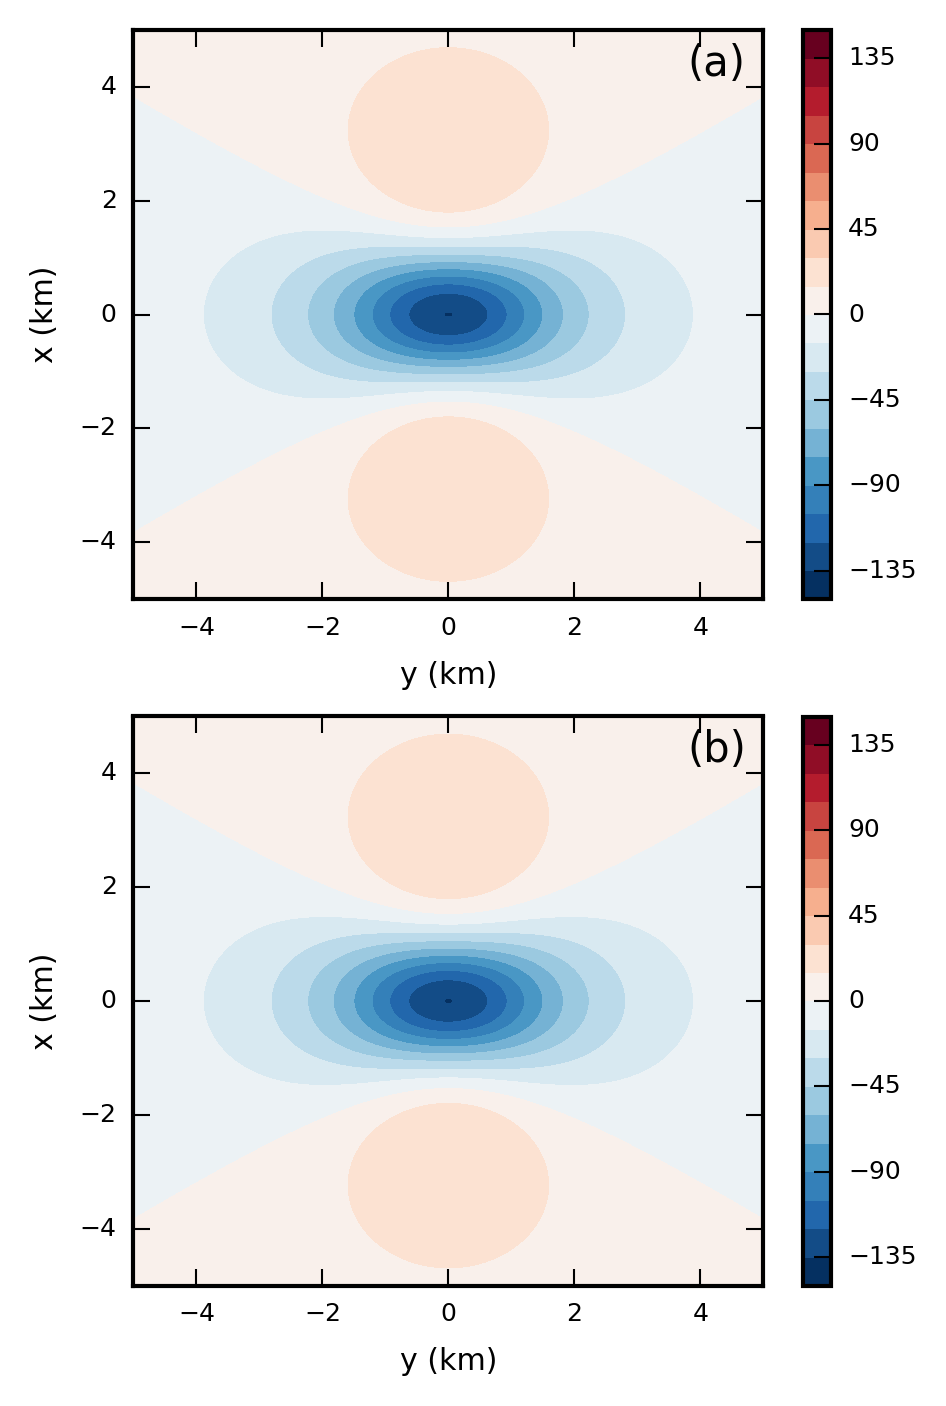

In [19]:
plt.close('all')
plt.figure(figsize=(3.15, 14./3))

plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf_r), np.max(tf_r)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(2,1,1)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_r.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(a)', xy=(0.88,0.92), 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)


ranges = np.max(np.abs([np.min(tf_n), np.max(tf_n)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(2,1,2)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_n.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(b)', xy=(0.88,0.92), 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

plt.tight_layout()
plt.savefig('..\\manuscript\\figures\\confocal_anomaly.pdf')

plt.show()

### Plot of the confocals ellipsoids

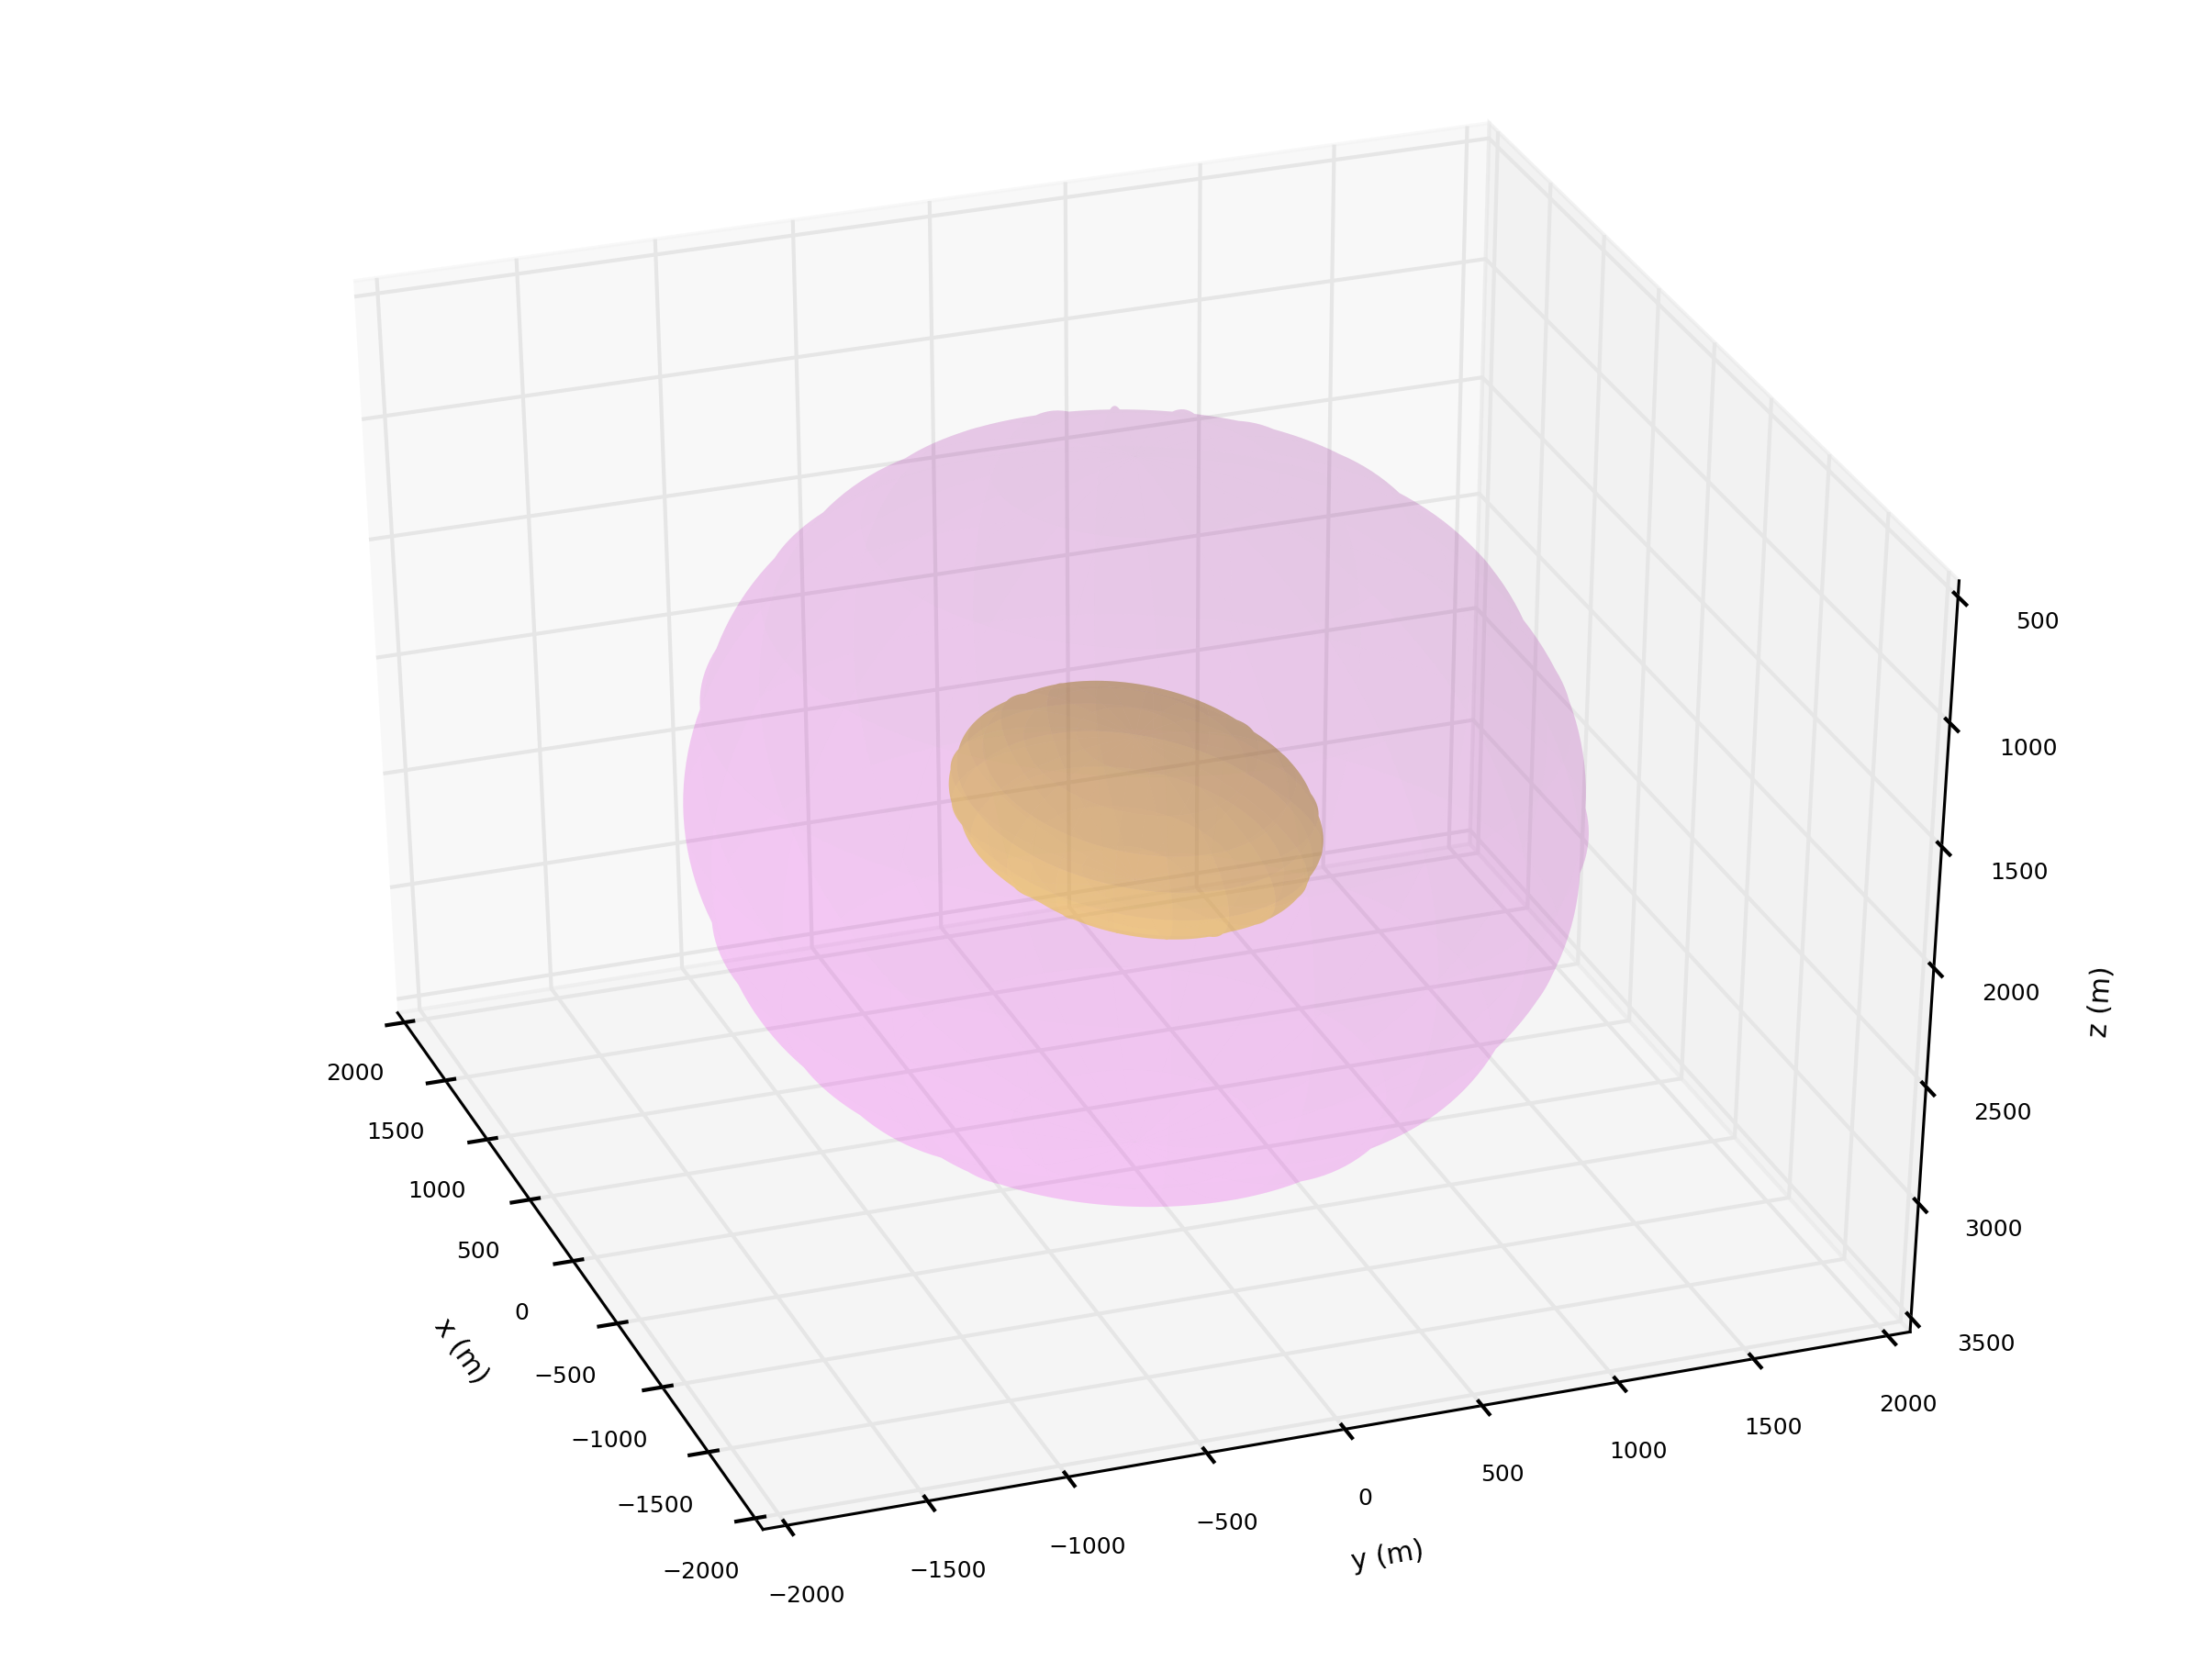

In [17]:
plt.close('all')
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

for m in ellipsoid:
    pf.draw_ellipsoid(ax, m, body_color=(1,1,0), body_alpha=0.3)

for m in ellipsoid2:
    pf.draw_ellipsoid(ax, m, body_color=(1,0,1), body_alpha=0.1)    

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

ax.view_init(215, 20)

plt.tight_layout(True)

plt.show()